<a href="https://colab.research.google.com/github/Apoorv070/Emotion_Detection/blob/master/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 32.62 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [2]:
import csv
data = {}
with open('/content/facial_expressions/data/legend.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    key = row[2].lower()
    if key in data:
      data[key].append(row[1])
    else:
      data[key] = [row[1]]

In [3]:
emotion_list = list(data.keys())
emotion_list

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [4]:
import os

os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')

In [5]:
for emotion in emotion_list:
  os.mkdir(os.path.join('master_data/training/', emotion))
  os.mkdir(os.path.join('master_data/testing/', emotion))

In [6]:
from shutil import copyfile
split_size = 0.8

for emotion, images in data.items():
  train_size = int(split_size*len(images))
  train_images = images[:train_size]
  test_images = images[train_size:]
  for image in train_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/training', emotion, image)
    copyfile(source, dest)
  for image in test_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/testing', emotion, image)
    copyfile(source, dest)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [8]:
model = tf.keras.models.Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape = (100, 100, 3)),
      MaxPooling2D(2, 2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(8, activation='softmax')
])
model.compile(optimizer = Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
train_dir = '/content/master_data/training'
test_dir = '/content/master_data/testing'

train_datagen = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size = (100, 100),
                                                    class_mode = 'categorical',
                                                    batch_size = 128
                                                  )

test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_generator = test_datagen.flow_from_directory(
                                                    test_dir,
                                                    target_size = (100, 100),
                                                    class_mode = 'categorical',
                                                    batch_size = 128
                                                  )

Found 10941 images belonging to 8 classes.
Found 2742 images belonging to 8 classes.


In [10]:
es = EarlyStopping(monitor='val_acc', patience = 2, min_delta=0.01)

In [14]:
history = model.fit_generator(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = test_generator,
                    callbacks = [es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
86/86 [==============================] - 18s 213ms/step - loss: 0.6209 - acc: 0.7825 - val_loss: 1.2979 - val_acc: 0.6123
Epoch 2/10
86/86 [==============================] - 18s 210ms/step - loss: 0.6191 - acc: 0.7878 - val_loss: 1.3488 - val_acc: 0.6265
Epoch 3/10
86/86 [==============================] - 18s 212ms/step - loss: 0.5992 - acc: 0.7922 - val_loss: 1.1377 - val_acc: 0.6623
Epoch 4/10
86/86 [==============================] - 18s 214ms/step - loss: 0.5973 - acc: 0.7984 - val_loss: 1.2478 - val_acc: 0.6543
Epoch 5/10
86/86 [==============================] - 18s 210ms/step - loss: 0.5943 - acc: 0.7910 - val_loss: 1.4133 - val_acc: 0.6357


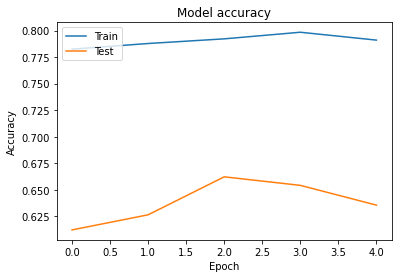

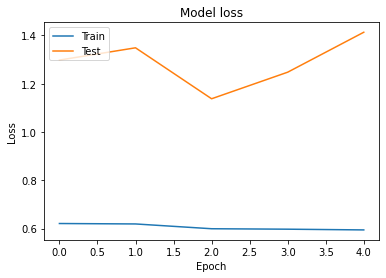

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.models import load_model

model.save('/content/drive/My Drive/model_facial.h5')